In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf
import xgboost as xgb
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'XGBoost'

In [4]:
f = yf.Ticker.get_info

In [18]:
msft = yf.Ticker("bbva.mc")
print(msft)

yfinance.Ticker object <BBVA.MC>


In [19]:
data = msft.history(period="max")

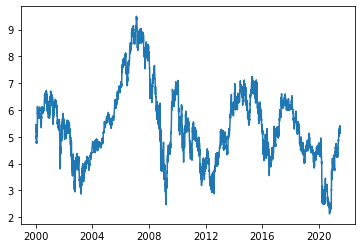

In [20]:
data = data.drop(columns=["Volume","Stock Splits","Dividends"])

In [21]:
data.head()

,Open,High,Low,Close
Date,,,,
2000-01-03,5.451844,5.478625,5.413585,5.425062
2000-01-04,5.356193,5.390626,5.264373,5.283502
2000-01-05,5.233766,5.260547,5.141946,5.164901
2000-01-06,5.164901,5.164901,5.164901,5.164901
2000-01-07,5.275852,5.275852,5.176380,5.229942


In [22]:
data = data.drop(columns=["High","Low",'Open'])

In [11]:
def train_test_split(data, n_test):
    """
    Function to split dataset into train and test
        - data
        - n_test: desired number of rows in test dataset
    """
    return data[:-n_test].reset_index(drop=True), data[-n_test:].reset_index(drop=True)

In [12]:
def series_to_supervised(data,n_inputs=10,n_outputs=1):
    """
    Function to transform time-series data to supervised training data
        - data
        - n_inputs: Number of days to look back
        - n_outputs: Number of days to look after
        - dropnan
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    new_data = pd.DataFrame(data)
    columns, names = list(), list()
    # With this loop we extract the input values, i.e. the values of the variables
    # for the previous n_inputs time steps
    for i in range(n_inputs, 0, -1):
        columns.append(new_data.shift(i))
        names += [('%s(t-%d)' % (data.columns[j], i)) for j in range(n_vars)]
    # With this loop we extract the actual values of the variables for the actual
    # time step and, if desired, we will add the next n_outputs time steps as columns
    for i in range(0, n_outputs):
        columns.append(new_data.shift(-i))  
        if i == 0:
            names += [('%s(t)' % (data.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (data.columns[j], i)) for j in range(n_vars)]
    data_result = pd.concat(columns, axis=1)
    data_result.columns = names
    data_result.dropna(inplace=True)
    data_result = data_result.infer_objects()
    return data_result

In [31]:
def fit(n_test, history=None):
    train_X, train_y = history.drop('Close(t)', axis=1), history.drop(history.columns.difference(['Close(t)']), axis=1)
    validation_model = xgb.XGBRegressor(objective='reg:squarederror',
                                        n_estimators=700,
                                        colsample_bytree=1,
                                        max_depth=3,
                                        reg_alpha=0,
                                        reg_lambda=1,
                                        subsample=0.9)
    validation_model.fit(train_X, train_y)
    return validation_model

In [53]:

def validate(data,n_test, flag=True):
    """
    Function that evaluates all the predictions obtained with our model with a walk forward validation method
        - data
        - n_test: desired number of predictions
    """
    predictions = list()
    expected = list()
    train,test = train_test_split(data,n_test)
    test_X, test_y = test.drop('Close(t)', axis=1), test.drop(test.columns.difference(['Close(t)']), axis=1)
    history = train.copy(deep=True)
    for i in range(n_test):
        test_X_iter, test_y_iter = test_X.iloc[i:i+1, :], test_y.iloc[i:i+1, :]
        test_model = fit(n_test, history=history)
        y_prediction = test_model.predict(test_X_iter)
        new_row = [test_X_iter.iloc[0, j] for j in range(len(test_X_iter.columns))]
        new_row.append(y_prediction[0])
        history.loc[len(history)] = new_row
        if flag==True:
            print("Prediction: %.3f | Expected: %.3f | GAP: %.3f" % (y_prediction[0], test_y_iter.iloc[0, 0], test_y_iter.iloc[0, 0] - y_prediction[0]))
        else:
            pass
        predictions.append(y_prediction[0])
        expected.append(test_y_iter.iloc[0, 0])
    mae = mean_absolute_error(expected, predictions)
    rmse = np.sqrt(mean_squared_error(expected, predictions))
    return expected, predictions, mae, rmse


In [54]:
def predict(self, test_X):
        return self.__model.predict(test_X)

In [55]:
data

,Close
Date,
2000-01-03,5.425062
2000-01-04,5.283502
2000-01-05,5.164901
2000-01-06,5.164901
2000-01-07,5.229942
...,...
2021-06-21,5.238000
2021-06-22,5.278000
2021-06-23,5.270000


In [56]:
final_data = series_to_supervised(data)

In [57]:
expected, predictions, mae, rmse = validate(final_data,50)

Prediction: 4.356 | Expected: 4.454 | GAP: 0.098
Prediction: 4.539 | Expected: 4.256 | GAP: -0.284
Prediction: 4.212 | Expected: 4.229 | GAP: 0.017
Prediction: 4.174 | Expected: 4.343 | GAP: 0.169
Prediction: 4.369 | Expected: 4.276 | GAP: -0.093
Prediction: 4.239 | Expected: 4.419 | GAP: 0.181
Prediction: 4.402 | Expected: 4.485 | GAP: 0.083
Prediction: 4.484 | Expected: 4.492 | GAP: 0.009
Prediction: 4.478 | Expected: 4.550 | GAP: 0.072
Prediction: 4.580 | Expected: 4.670 | GAP: 0.091
Prediction: 4.671 | Expected: 4.676 | GAP: 0.005
Prediction: 4.679 | Expected: 4.665 | GAP: -0.014
Prediction: 4.723 | Expected: 4.773 | GAP: 0.050
Prediction: 4.727 | Expected: 4.806 | GAP: 0.079
Prediction: 4.785 | Expected: 4.821 | GAP: 0.037
Prediction: 4.798 | Expected: 4.928 | GAP: 0.130
Prediction: 5.022 | Expected: 4.909 | GAP: -0.113
Prediction: 4.902 | Expected: 4.903 | GAP: 0.001
Prediction: 4.887 | Expected: 4.892 | GAP: 0.005
Prediction: 4.816 | Expected: 5.028 | GAP: 0.212
Prediction: 5.06

In [63]:
mae

0.07286932945251465

In [64]:
rmse

0.09576796623115315

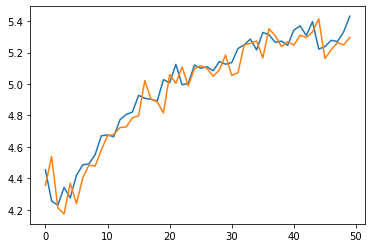

In [66]:
plt.plot(expected)
plt.plot(predictions)

## Prediccion without data

In [69]:
data_final = series_to_supervised(data)
expected, predictions, mae, rmse = validate(data_final,1)
print(predictions)
data.drop(data.tail(1).index,inplace=True)
data_new = pd.concat([data,pd.DataFrame(predictions,columns=['Close'])], axis=0, names=data.columns.tolist())
data_final_ = series_to_supervised(data_new)
history = data_new.copy()
for i in range(9):
    expected, predictions, mae, rmse = validate(data_final_,1,False)
    history = pd.concat([history,pd.DataFrame(predictions,columns=['Close'])], axis=0, names=history.columns.tolist())
    data_final_ = series_to_supervised(history)

Prediction: 5.257 | Expected: 5.330 | GAP: 0.073
[5.2573457]


In [70]:
prediction =history.tail(11)
history = history.drop(history.tail(11).index)
idx = pd.date_range(history.tail(1).index[0], periods=12, freq="D")
idx = np.delete(idx, 0)

In [71]:
prediction.set_index(idx, inplace = True)

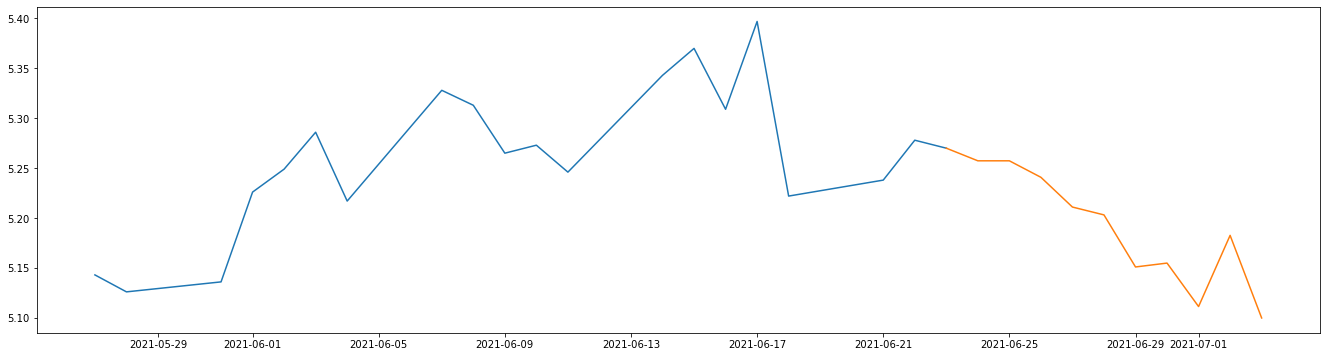

In [72]:
plt.rcParams["figure.figsize"] = (23,6)
plt.plot(data.tail(20))
plt.plot(prediction)

## Optimizate

In [74]:
def optimize(data, n_test):
    # GridSearchCV to find the best parameters for the XGBRegressor
    train, test = train_test_split(data,n_test)
    train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1:]
    param_grid = {
        'objective': ['reg:squarederror', 'reg:linear'],
        'n_estimators': [400, 700, 1000],
        'colsample_bytree': [0.7, 0.8, 1],
        'max_depth': [3, 6, 9],
        'reg_alpha': [0, 0.2, 0.4],
        'reg_lambda': [1, 1.2, 1.4],
        'subsample': [0.7, 0.8, 0.9]
    }
    opt_model = xgb.XGBRegressor()
    grid = GridSearchCV(opt_model,
                        param_grid,
                        scoring='neg_mean_absolute_error',
                        cv=5,
                        n_jobs=5,
                        verbose=True)
    grid.fit(train_X, train_y)
    return grid.best_score_, grid.best_params_

In [75]:
a,b = optimize(final_data,50)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   23.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.9min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 13.1min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed: 24.9min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed: 47.1min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 79.2min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed: 93.2min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 123.3min
[Parallel(n_jobs=5)]: Done 4990 tasks      | elapsed: 156.6min
[Parallel(n_jobs=5)]: Done 6040 tasks      | elapsed: 180.2min
[Parallel(n_jobs=5)]: Done 7190 tasks      | elapsed: 231.8min
[Parallel(n_jobs=5)]: Done 7290 out of 7290 | elapsed: 238.5min finished


In [76]:
a

-0.1894838553218392

In [77]:
b

{'colsample_bytree': 1,
 'max_depth': 3,
 'n_estimators': 400,
 'objective': 'reg:squarederror',
 'reg_alpha': 0,
 'reg_lambda': 1.2,
 'subsample': 0.8}